In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

from imblearn.under_sampling import AllKNN
from collections import Counter

# Ajustes de estilo
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [83]:
# ------------------------------------------------------------
# 1) CARGA DEL CSV E IMPUTACIONES “DE NEGOCIO”
# ------------------------------------------------------------
csv_path = 'data/hotel_bookings.csv'
if not os.path.exists(csvs := csv_path):
    raise FileNotFoundError(f"El archivo '{csvs}' no se ha encontrado.")

df = pd.read_csv(csv_path)

# Eliminar columnas irrelevantes o con muchos nulos
df.drop(columns=['reservation_status', 'company'], inplace=True, errors='ignore')

# Imputaciones “de negocio”
df['agent']    = df['agent'].fillna(0).astype(int)
df['children'] = df['children'].fillna(0).astype(int)
df['country']  = df['country'].fillna('Unknown').astype('category')

# Convertir reservation_status_date a datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%Y-%m-%d', errors='coerce')



No se encontraron reglas significativas para el objetivo.


/tmp/ipykernel_6733/2641640252.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


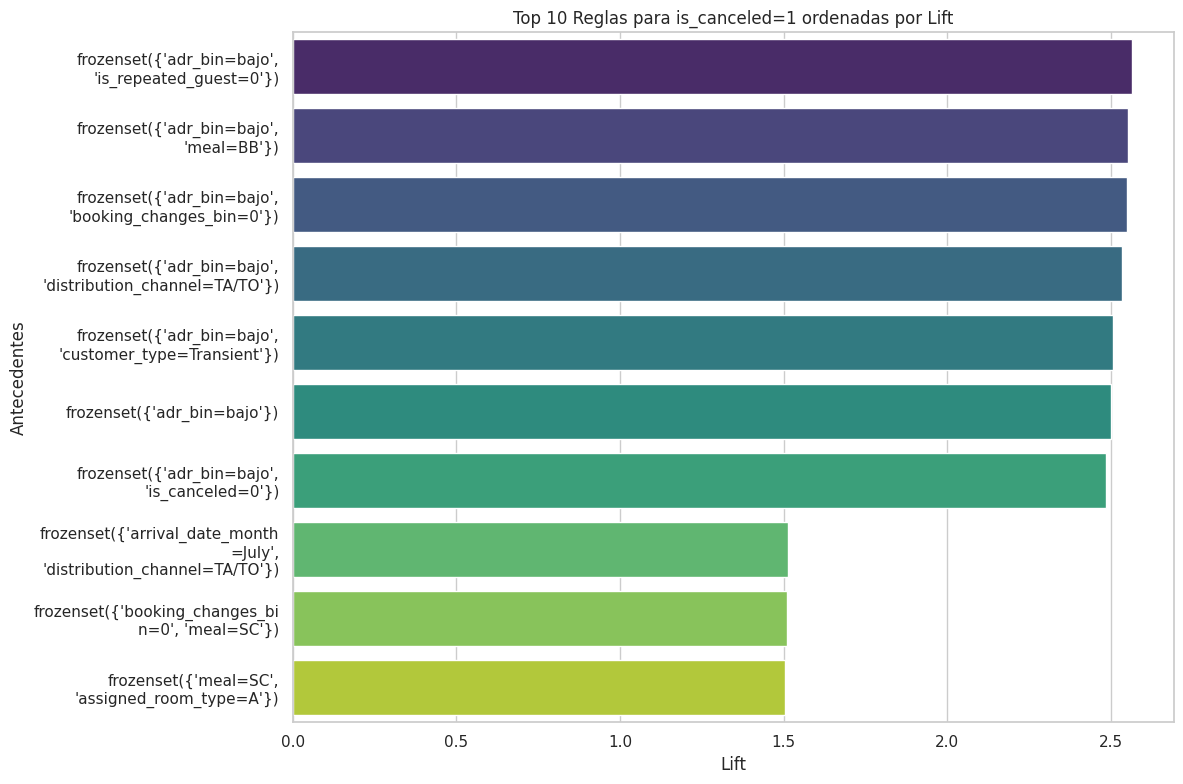


Resumen de las mejores reglas:

                                          antecedents              consequents  support  confidence     lift   impact
                  (adr_bin=bajo, is_repeated_guest=0)     (hotel=Resort Hotel) 0.076363    0.860419 2.564289 0.195817
                              (adr_bin=bajo, meal=BB)     (hotel=Resort Hotel) 0.077536    0.856099 2.551415 0.197826
                (adr_bin=bajo, booking_changes_bin=0)     (hotel=Resort Hotel) 0.068624    0.855398 2.549325 0.174944
           (adr_bin=bajo, distribution_channel=TA/TO)     (hotel=Resort Hotel) 0.052718    0.850196 2.533821 0.133578
              (adr_bin=bajo, customer_type=Transient)     (hotel=Resort Hotel) 0.060952    0.841272 2.507225 0.152819
                                       (adr_bin=bajo)     (hotel=Resort Hotel) 0.084304    0.839030 2.500543 0.210805
                        (adr_bin=bajo, is_canceled=0)     (hotel=Resort Hotel) 0.066019    0.833898 2.485248 0.164073
(arrival_date_month=Jul

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# ------------------------------------------------------------
# 2) REGLAS DE ASOCIACIÓN
# ------------------------------------------------------------
def prepare_numeric_bins(df):
    """
    Crea nuevas columnas categóricas a partir de variables numéricas clave mediante binning.
    Devuelve un DataFrame con las columnas originales más las nuevas categorizadas.
    """
    df = df.copy()

    # lead_time: tiempo entre reserva y llegada
    df['lead_time_bin'] = pd.cut(
        df['lead_time'],
        bins=[-1, 7, 30, 90, df['lead_time'].max()],
        labels=['<=1 semana', '1-4 semanas', '1-3 meses', '>3 meses']
    )

    # adr: precio medio diario
    df['adr_bin'] = pd.cut(
        df['adr'],
        bins=[-1, 50, 100, 150, df['adr'].max()],
        labels=['bajo', 'medio', 'alto', 'muy alto']
    )

    # stays_in_week_nights
    df['stays_week_bin'] = pd.cut(
        df['stays_in_week_nights'],
        bins=[-1, 0, 2, 5, df['stays_in_week_nights'].max()],
        labels=['0', '1-2', '3-5', '>5']
    )

    # stays_in_weekend_nights
    df['stays_weekend_bin'] = pd.cut(
        df['stays_in_weekend_nights'],
        bins=[-1, 0, 1, 2, df['stays_in_weekend_nights'].max()],
        labels=['0', '1', '2', '>=3']
    )

    # total_of_special_requests
    df['special_requests_bin'] = pd.cut(
        df['total_of_special_requests'],
        bins=[-1, 0, 1, df['total_of_special_requests'].max()],
        labels=['0', '1', '2+']
    )

    # previous_cancellations
    df['prev_cancellations_bin'] = pd.cut(
        df['previous_cancellations'],
        bins=[-1, 0, 1, df['previous_cancellations'].max()],
        labels=['0', '1', '2+']
    )

    # days_in_waiting_list
    df['waiting_days_bin'] = pd.cut(
        df['days_in_waiting_list'],
        bins=[-1, 0, 10, 30, df['days_in_waiting_list'].max()],
        labels=['0', '1-10', '11-30', '>30']
    )

    # booking_changes
    df['booking_changes_bin'] = pd.cut(
        df['booking_changes'],
        bins=[-1, 0, 1, df['booking_changes'].max()],
        labels=['0', '1', '2+']
    )

    return df


def improved_association_analysis(df, target_var='is_canceled', min_support=0.05, min_confidence=0.6, obj=False):
    """
    Realiza un análisis de reglas de asociación mejorado para predecir cancelaciones de hotel.
    """
    # 1. Selección inteligente de columnas
    cols = [
        'hotel', 'arrival_date_month', 'meal', 'market_segment',
        'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
        'assigned_room_type', 'customer_type',
        'lead_time_bin', 'adr_bin', 'stays_in_week_nights_bin',
        'booking_changes_bin', 'previous_cancellations_bin',
        'total_of_special_requests_bin', 'days_in_waiting_list_bin',
        target_var
    ]
    cols = [col for col in cols if col in df.columns]
    
    # 2. Preprocesamiento optimizado
    df_assoc = df[cols].copy()
    for col in cols:
        if df_assoc[col].dtype == 'category':
            df_assoc[col] = df_assoc[col].astype(str)
        elif df_assoc[col].dtype == 'object':
            if df_assoc[col].nunique() > 20:
                top_categories = df_assoc[col].value_counts().nlargest(10).index
                df_assoc[col] = df_assoc[col].where(df_assoc[col].isin(top_categories), 'Other')
    
    # 3. Creación de transacciones
    transactions = [
        [f"{col}={row[col]}" for col in cols]
        for _, row in df_assoc.iterrows()
    ]
    
    # 4. Codificación
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    # 5. Apriori
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True, low_memory=True)
    
    # 6. Reglas de asociación
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    if obj:
        rules = rules[
            (rules['antecedents'].apply(len) <= 2) &
            (rules['consequents'].apply(len) == 1) &
            (rules['consequents'].astype(str).str.contains(f"{target_var}="))
        ]
    else:
        rules = rules[
            (rules['antecedents'].apply(len) <= 2) &
            (rules['consequents'].apply(len) == 1)
        ]   

    rules['impact'] = rules['support'] * rules['lift']
    
    # 7. Visualización
    plot_top_rules(rules, target_value=f"{target_var}=1", obj = obj)
    
    return rules.sort_values(by=['lift', 'confidence'], ascending=False)

def plot_top_rules(rules, target_value, top_n=10, obj = False):
    """Visualiza las mejores reglas que predicen el valor objetivo."""
    if obj:
        target_rules = rules[rules['consequents'].astype(str).str.contains(target_value)]
    else:
        target_rules = rules

    if len(target_rules) == 0:
        print("No se encontraron reglas significativas para el objetivo.")
        return
    
    top_rules = target_rules.sort_values(by='lift', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='lift',
        y=top_rules['antecedents'].astype(str).str.wrap(30),
        data=top_rules,
        palette='viridis'
    )
    plt.title(f"Top {top_n} Reglas para {target_value} ordenadas por Lift")
    plt.xlabel("Lift")
    plt.ylabel("Antecedentes")
    plt.tight_layout()
    plt.show()
    
    # Mostrar resumen en tabla
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'impact']
    print("\nResumen de las mejores reglas:\n")
    print(top_rules[display_cols].sort_values(by='lift', ascending=False).to_string(index=False))


df_binned = prepare_numeric_bins(df)
rules_cancel = improved_association_analysis(df_binned, target_var='is_canceled', obj=True)

rules_cancel = improved_association_analysis(df_binned, target_var='is_canceled', obj=False)


In [85]:
# ------------------------------------------------------------
# 3) LIMPIEZA CON ALLKNN PARA ELIMINAR RUIDO
# ------------------------------------------------------------
# Definir target y características
target = 'is_canceled'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

# Convertir 'reservation_status_date' a ordinal (entero) para AllKNN
X['reservation_status_date'] = X['reservation_status_date'].map(lambda dt: dt.toordinal())

# Separar numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Imputar numéricas faltantes con mediana
imp_num = SimpleImputer(strategy='median')
X_num = pd.DataFrame(imp_num.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

# Imputar categóricas faltantes con la moda
imp_cat = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(imp_cat.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)

# Concatenar numéricas y categóricas
X_imputed = pd.concat([X_num, X_cat], axis=1)

# Label Encoding para columnas categóricas
X_encoded = X_imputed.copy()
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    le_dict[col] = le

print("Forma antes de AllKNN:")
print(" X_encoded:", X_encoded.shape, " y:", y.shape)

# Aplicar AllKNN
allknn = AllKNN()
X_res, y_res = allknn.fit_resample(X_encoded, y)

print("\nForma después de AllKNN:")
print(" X_res:", X_res.shape, " y_res:", y_res.shape)
print("\nDistribución de clases antes de AllKNN:", Counter(y))
print("Distribución de clases después de AllKNN:", Counter(y_res))


Forma antes de AllKNN:
 X_encoded: (119390, 29)  y: (119390,)

Forma después de AllKNN:
 X_res: (103030, 29)  y_res: (103030,)

Distribución de clases antes de AllKNN: Counter({0: 75166, 1: 44224})
Distribución de clases después de AllKNN: Counter({0: 58806, 1: 44224})


In [86]:

# ------------------------------------------------------------
# 4) RECONSTRUIR df_res (dataset remuestreado)
# ------------------------------------------------------------
df_res = pd.DataFrame(X_res, columns=X_encoded.columns)
df_res[target] = y_res.values

# Volver a mapear 'reservation_status_date' de ordinal a fecha
# (Opcional: si se quiere usar como datetime para análisis estacional)
df_res['reservation_status_date'] = df_res['reservation_status_date'].map(lambda x: pd.Timestamp.fromordinal(int(x)))

# Devolver tipo categórico a columnas originales (donde corresponde)
for col in cat_cols:
    # Hacemos inverso de LabelEncoder
    df_res[col] = le_dict[col].inverse_transform(df_res[col].astype(int))

# Reconstruir variables de fecha de llegada
# Nota: 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month' ya estaban en df_encoded
# No se codificaron, por tanto siguen en df_res como ordinales (?), en este ejemplo las dejamos como están.




=== ANÁLISIS 1: Cancelaciones por segmento y canal ===

Tasa de cancelación por market_segment:
  market_segment  is_canceled
7      Undefined     1.000000
4         Groups     0.622466
6      Online TA     0.446971
5  Offline TA/TO     0.370052
0       Aviation     0.285714
2      Corporate     0.224638
3         Direct     0.201521
1  Complementary     0.179298

Tasa de cancelación por distribution_channel:
  distribution_channel  is_canceled
4            Undefined     0.800000
3                TA/TO     0.468256
2                  GDS     0.260563
0            Corporate     0.258960
1               Direct     0.223455


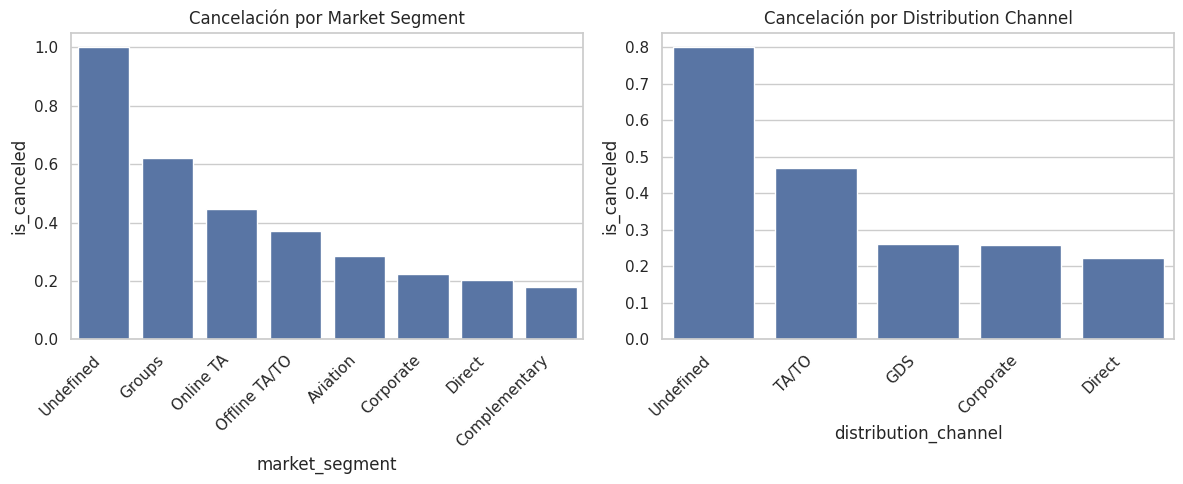

In [87]:
# ------------------------------------------------------------
# 4) ANÁLISIS 1: Cancelaciones por market_segment y distribution_channel
# ------------------------------------------------------------
print("\n=== ANÁLISIS 1: Cancelaciones por segmento y canal ===")
cancel_by_segment = df_res.groupby('market_segment')[target].mean().reset_index().sort_values(by=target, ascending=False)
cancel_by_channel = df_res.groupby('distribution_channel')[target].mean().reset_index().sort_values(by=target, ascending=False)

print("\nTasa de cancelación por market_segment:")
print(cancel_by_segment)

print("\nTasa de cancelación por distribution_channel:")
print(cancel_by_channel)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(data=cancel_by_segment, x='market_segment', y=target)
plt.xticks(rotation=45, ha='right')
plt.title('Cancelación por Market Segment')

plt.subplot(1,2,2)
sns.barplot(data=cancel_by_channel, x='distribution_channel', y=target)
plt.xticks(rotation=45, ha='right')
plt.title('Cancelación por Distribution Channel')

plt.tight_layout()
plt.show()


=== ANÁLISIS 2: Lead_time vs Cancelación y ADR ===
  lead_time_range  cancel_rate     avg_adr  n_reservas
0             0-7     0.120152   85.996986       15830
1            8-30     0.346836  104.763517       15232
2           31-90     0.444112  103.982304       25086
3             91+     0.552408  100.049930       46882


/tmp/ipykernel_6733/2356454738.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_lead = df_res.groupby('lead_time_range').agg({


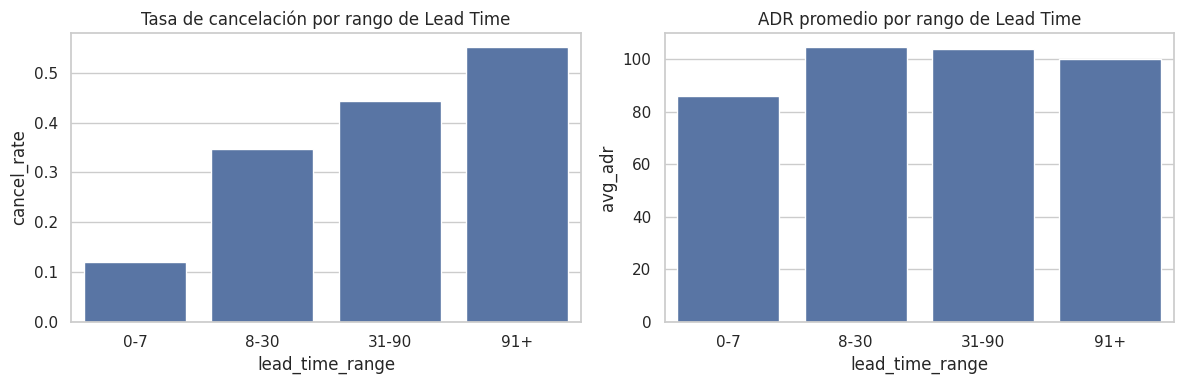

In [88]:
# ------------------------------------------------------------
# 5) ANÁLISIS 2: Efecto de lead_time en cancelaciones y ADR
# ------------------------------------------------------------
print("\n=== ANÁLISIS 2: Lead_time vs Cancelación y ADR ===")
# Crear rangos de lead_time
bins = [0, 7, 30, 90, df_res['lead_time'].max()]
labels = ['0-7', '8-30', '31-90', '91+']
df_res['lead_time_range'] = pd.cut(df_res['lead_time'], bins=bins, labels=labels, include_lowest=True)

agg_lead = df_res.groupby('lead_time_range').agg({
    target: 'mean',
    'adr': 'mean',
    'lead_time': 'count'
}).rename(columns={target: 'cancel_rate', 'adr': 'avg_adr', 'lead_time': 'n_reservas'}).reset_index()

print(agg_lead)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(data=agg_lead, x='lead_time_range', y='cancel_rate')
plt.title('Tasa de cancelación por rango de Lead Time')

plt.subplot(1,2,2)
sns.barplot(data=agg_lead, x='lead_time_range', y='avg_adr')
plt.title('ADR promedio por rango de Lead Time')

plt.tight_layout()
plt.show()


=== ANÁLISIS 3: Estacionalidad ===

Tasa de cancelación y ADR por mes:
   arrival_date_month  cancel_rate     avg_adr  n_reservas
0             January     0.379462   68.305691        4762
1            February     0.394671   71.819256        6831
2               March     0.377669   78.794112        8338
3               April     0.468517   97.486482        9656
4                 May     0.461288  105.648898       10139
5                June     0.488527  113.791883        9283
6                July     0.449991  121.963113       10538
7              August     0.428023  138.053315       12240
8           September     0.445358  102.862337        9242
9             October     0.425536   87.160195        9978
10           November     0.354790   72.769972        5981
11           December     0.392420   80.080738        6042


/tmp/ipykernel_6733/4161927644.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_month = df_res.groupby('arrival_date_month').agg({


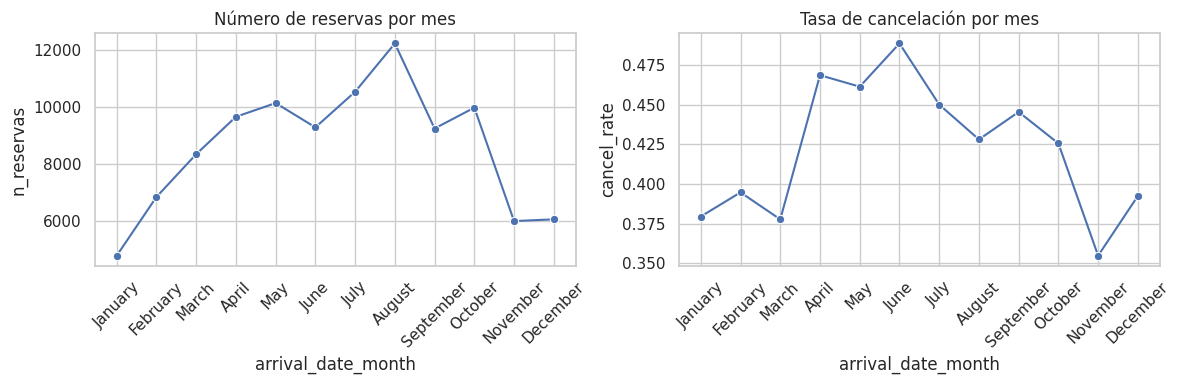


Tasa de cancelación: Fines de semana vs Entre semana
   es_finde  cancel_rate
0     False     0.432152
1      True     0.405585


In [89]:
# ------------------------------------------------------------
# 6) ANÁLISIS 3: Estacionalidad (mes, semana, fines de semana vs. semana)
# ------------------------------------------------------------
print("\n=== ANÁLISIS 3: Estacionalidad ===")
# Convertir arrival_date_month a categoría ordinal para orden
meses_orden = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_res['arrival_date_month'] = pd.Categorical(df_res['arrival_date_month'], categories=meses_orden, ordered=True)

# Agrupar por mes: número de reservas y tasa de cancelación
agg_month = df_res.groupby('arrival_date_month').agg({
    target: 'mean',
    'adr': 'mean',
    'arrival_date_month': 'count'
}).rename(columns={target:'cancel_rate','adr':'avg_adr','arrival_date_month':'n_reservas'}).reset_index()

print("\nTasa de cancelación y ADR por mes:")
print(agg_month)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.lineplot(data=agg_month, x='arrival_date_month', y='n_reservas', marker='o')
plt.xticks(rotation=45)
plt.title('Número de reservas por mes')

plt.subplot(1,2,2)
sns.lineplot(data=agg_month, x='arrival_date_month', y='cancel_rate', marker='o')
plt.xticks(rotation=45)
plt.title('Tasa de cancelación por mes')

plt.tight_layout()
plt.show()

# Comparar fines de semana vs entre semana
df_res['total_nights'] = df_res['stays_in_weekend_nights'] + df_res['stays_in_week_nights']
df_res['es_finde'] = df_res['stays_in_weekend_nights'] > df_res['stays_in_week_nights']

agg_finde = df_res.groupby('es_finde')[target].mean().reset_index().rename(columns={target:'cancel_rate'})
print("\nTasa de cancelación: Fines de semana vs Entre semana")
print(agg_finde)



=== ANÁLISIS 4: Segmentación y CLTV aproximado ===
     customer_type  avg_revenue  cancel_rate  pct_repeated  \
0         Contract   451.853036     0.342377      0.008410   
1            Group   250.578094     0.126338      0.261242   
2        Transient   379.895916     0.483687      0.031315   
3  Transient-Party   257.306050     0.273198      0.021038   

   avg_prev_not_canceled  avg_prev_canceled    est_cltv  
0               0.003527           0.249322  566.103451  
1               0.516060           0.038544  389.549671  
2               0.148124           0.084129  468.127826  
3               0.048405           0.119773  300.579149  


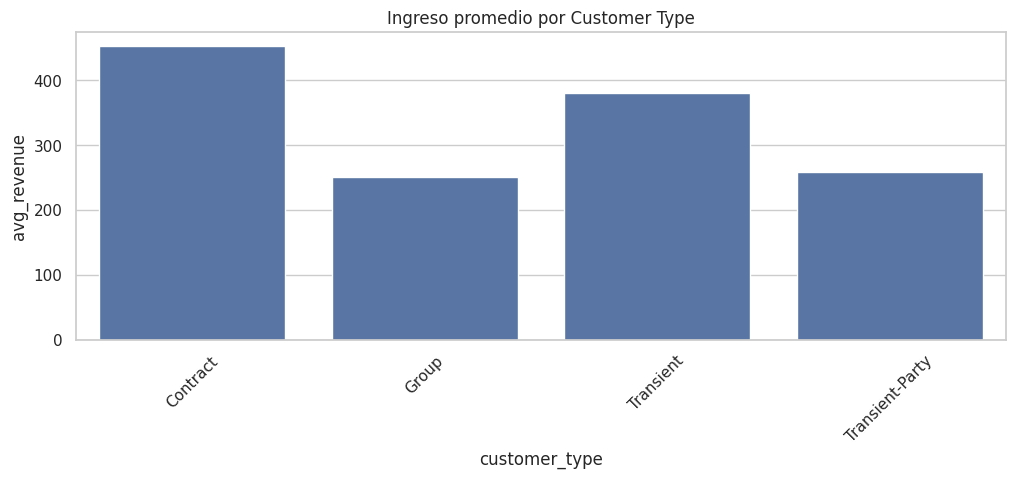

In [90]:
# ------------------------------------------------------------
# 7) ANÁLISIS 4: Segmentación de clientes y CLTV aproximado
# ------------------------------------------------------------
print("\n=== ANÁLISIS 4: Segmentación y CLTV aproximado ===")
# Calcular ingreso por reserva
df_res['total_revenue'] = df_res['adr'] * df_res['total_nights']

# Agregar por customer_type
agg_cust = df_res.groupby('customer_type').agg({
    'total_revenue': 'mean',
    target: 'mean',
    'is_repeated_guest': 'mean',
    'previous_bookings_not_canceled': 'mean',
    'previous_cancellations': 'mean'
}).rename(columns={
    'total_revenue':'avg_revenue',
    target:'cancel_rate',
    'is_repeated_guest':'pct_repeated',
    'previous_bookings_not_canceled':'avg_prev_not_canceled',
    'previous_cancellations':'avg_prev_canceled'
}).reset_index()

# Estimar CLTV aproximado: ingresos promedio * avg de reservas totales
agg_cust['est_cltv'] = agg_cust['avg_revenue'] * (agg_cust['avg_prev_not_canceled'] + agg_cust['avg_prev_canceled'] + 1)

print(agg_cust)

plt.figure(figsize=(12,4))
sns.barplot(data=agg_cust, x='customer_type', y='avg_revenue')
plt.title('Ingreso promedio por Customer Type')
plt.xticks(rotation=45)
plt.show()



=== ANÁLISIS 5: Reserva vs Asignación de habitación ===
  reserved_room_type  pct_reasignacion  cancel_rate  n_reservas
0                  A          0.134582     0.440529       76340
1                  B          0.094319     0.394427         933
2                  C          0.048452     0.414536         743
3                  D          0.067526     0.385446       15831
4                  E          0.086095     0.364571        5250
5                  F          0.053854     0.434783        2024
6                  G          0.024506     0.519401        1469
7                  H          0.023585     0.577830         424
8                  L          0.750000     0.500000           4
9                  P          0.000000     1.000000          12


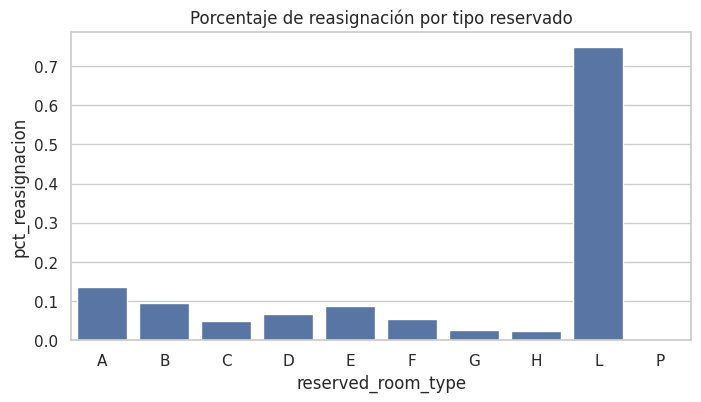

In [91]:

# ------------------------------------------------------------
# 8) ANÁLISIS 5: Reserva vs Asignación de tipo de habitación
# ------------------------------------------------------------
print("\n=== ANÁLISIS 5: Reserva vs Asignación de habitación ===")
df_res['misaligned_room'] = df_res['reserved_room_type'] != df_res['assigned_room_type']

agg_room = df_res.groupby('reserved_room_type').agg({
    'misaligned_room':'mean',
    target:'mean',
    'reserved_room_type':'count'
}).rename(columns={
    'misaligned_room':'pct_reasignacion',
    target:'cancel_rate',
    'reserved_room_type':'n_reservas'
}).reset_index()

print(agg_room)

plt.figure(figsize=(8,4))
sns.barplot(data=agg_room, x='reserved_room_type', y='pct_reasignacion')
plt.title('Porcentaje de reasignación por tipo reservado')
plt.show()


=== ANÁLISIS 6: Peticiones especiales ===
  req_group  cancel_rate     avg_adr  avg_nights
0         0     0.526088   93.729984    3.299056
1         1     0.270666  106.234651    3.657395
2         2     0.284156  113.718119    3.869522
3        3+     0.227979  121.728950    4.090909


/tmp/ipykernel_6733/1584901538.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_req = df_res.groupby('req_group').agg({


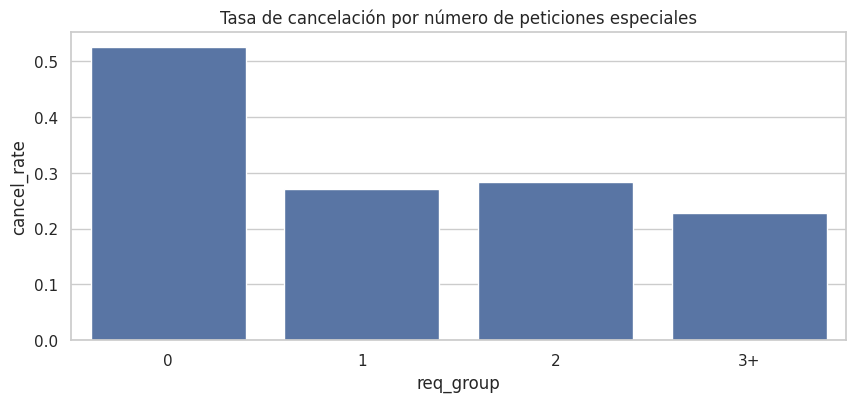

In [92]:
# ------------------------------------------------------------
# 9) ANÁLISIS 6: Peticiones especiales (total_of_special_requests)
# ------------------------------------------------------------
print("\n=== ANÁLISIS 6: Peticiones especiales ===")
# Crear grupos por número de requests (0,1,2,3+)
df_res['req_group'] = pd.cut(df_res['total_of_special_requests'],
                            bins=[-1,0,1,2, np.inf],
                            labels=['0','1','2','3+'])

agg_req = df_res.groupby('req_group').agg({
    target:'mean',
    'adr':'mean',
    'total_nights':'mean'
}).rename(columns={target:'cancel_rate','adr':'avg_adr','total_nights':'avg_nights'}).reset_index()

print(agg_req)

plt.figure(figsize=(10,4))
sns.barplot(data=agg_req, x='req_group', y='cancel_rate')
plt.title('Tasa de cancelación por número de peticiones especiales')
plt.show()


=== ANÁLISIS 7: Lista de espera ===
Tasa de cancelación (con lista de espera >0): 0.650
Tasa de cancelación (sin lista de espera): 0.421


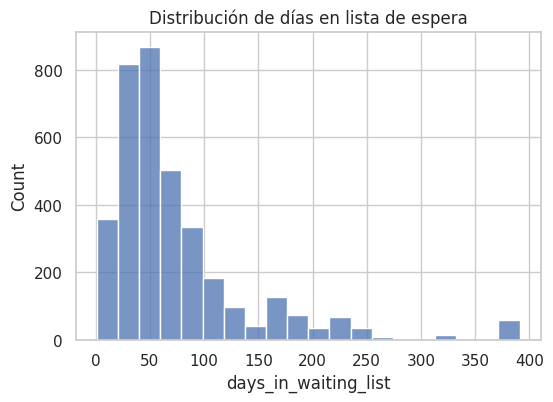

In [93]:
# ------------------------------------------------------------
# 10) ANÁLISIS 7: Días en lista de espera (days_in_waiting_list)
# ------------------------------------------------------------
print("\n=== ANÁLISIS 7: Lista de espera ===")
df_wait = df_res[df_res['days_in_waiting_list'] > 0].copy()
df_no_wait = df_res[df_res['days_in_waiting_list'] == 0].copy()

wait_cancel_rate = df_wait[target].mean()
no_wait_cancel_rate = df_no_wait[target].mean()

print(f"Tasa de cancelación (con lista de espera >0): {wait_cancel_rate:.3f}")
print(f"Tasa de cancelación (sin lista de espera): {no_wait_cancel_rate:.3f}")

# Distribución de días en lista
plt.figure(figsize=(6,4))
sns.histplot(df_wait['days_in_waiting_list'], bins=20, kde=False)
plt.title('Distribución de días en lista de espera')
plt.show()




=== ANÁLISIS 8: Uso de parking ===
   required_car_parking_spaces  cancel_rate     avg_adr  n_reservas
0                          0.0      0.45248   99.200430       97737
1                          1.0      0.00000  105.879878        5264
2                          2.0      0.00000  114.306800          25
3                          3.0      0.00000  124.665000           2
4                          8.0      0.00000   60.000000           2


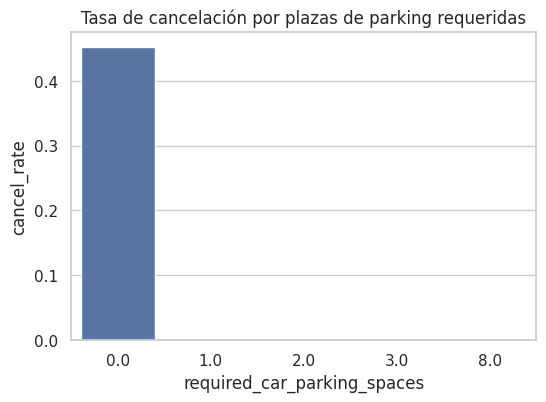

In [94]:
# ------------------------------------------------------------
# 11) ANÁLISIS 8: Uso de estacionamiento (required_car_parking_spaces)
# ------------------------------------------------------------
print("\n=== ANÁLISIS 8: Uso de parking ===")
agg_park = df_res.groupby('required_car_parking_spaces').agg({
    target:'mean',
    'adr':'mean',
    'required_car_parking_spaces':'count'
}).rename(columns={
    target:'cancel_rate',
    'adr':'avg_adr',
    'required_car_parking_spaces':'n_reservas'
}).reset_index()

print(agg_park.head(5))

plt.figure(figsize=(6,4))
sns.barplot(data=agg_park, x='required_car_parking_spaces', y='cancel_rate')
plt.title('Tasa de cancelación por plazas de parking requeridas')
plt.show()


=== ANÁLISIS 9: Huéspedes repetidos ===
   is_repeated_guest  cancel_rate     avg_adr  avg_nights  avg_special_reqs  \
0                0.0     0.436628  100.667238    3.512022          0.521530   
1                1.0     0.183450   62.244364    1.910602          0.569957   

       tipo  
0     Nuevo  
1  Repetido  


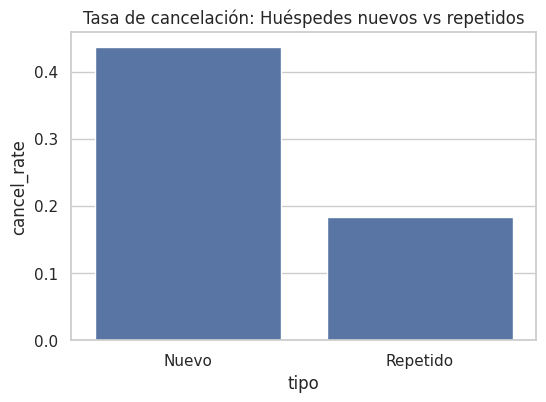

In [95]:

# ------------------------------------------------------------
# 12) ANÁLISIS 9: Comportamiento de huéspedes repetidos
# ------------------------------------------------------------
print("\n=== ANÁLISIS 9: Huéspedes repetidos ===")
agg_repeat = df_res.groupby('is_repeated_guest').agg({
    target:'mean',
    'adr':'mean',
    'total_nights':'mean',
    'total_of_special_requests':'mean'
}).rename(columns={
    target:'cancel_rate',
    'adr':'avg_adr',
    'total_nights':'avg_nights',
    'total_of_special_requests':'avg_special_reqs'
}).reset_index()

agg_repeat['tipo'] = agg_repeat['is_repeated_guest'].map({0:'Nuevo', 1:'Repetido'})
print(agg_repeat)

plt.figure(figsize=(6,4))
sns.barplot(data=agg_repeat, x='tipo', y='cancel_rate')
plt.title('Tasa de cancelación: Huéspedes nuevos vs repetidos')
plt.show()


=== ANÁLISIS 10: ADR por temporada y canal ===
   arrival_date_month         adr
0             January   68.305691
1            February   71.819256
2               March   78.794112
3               April   97.486482
4                 May  105.648898
5                June  113.791883
6                July  121.963113
7              August  138.053315
8           September  102.862337
9             October   87.160195
10           November   72.769972
11           December   80.080738


/tmp/ipykernel_6733/3795854962.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_month_adr = df_res.groupby('arrival_date_month')['adr'].mean().reset_index()


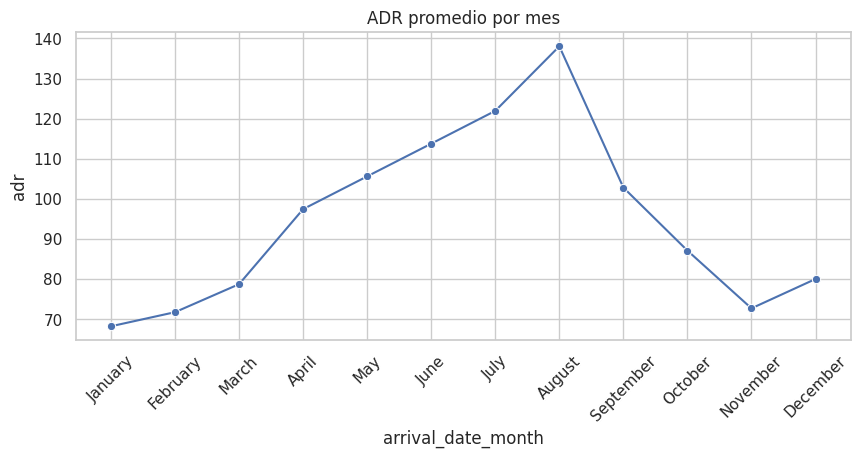


ADR promedio por distribution_channel:
  distribution_channel         adr
2                  GDS  121.882746
1               Direct  102.495379
3                TA/TO  101.168567
0            Corporate   68.646453
4            Undefined   46.240000


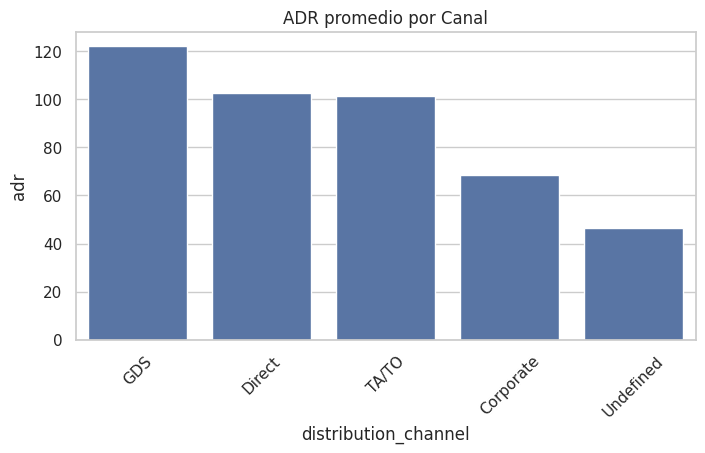

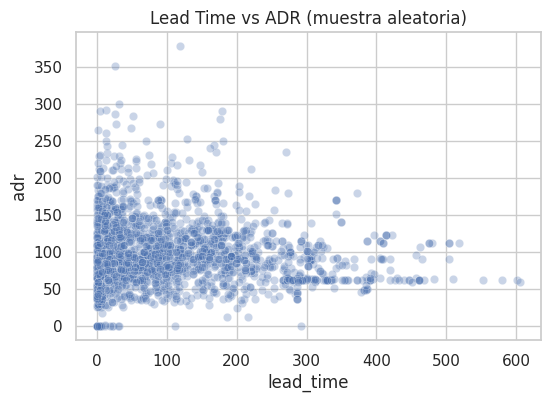

In [96]:
# ------------------------------------------------------------
# 13) ANÁLISIS 10: ADR por temporada y canal
# ------------------------------------------------------------
print("\n=== ANÁLISIS 10: ADR por temporada y canal ===")
# ADR promedio por mes (ya tenemos agg_month de antes), pero recalculamos con df_res
agg_month_adr = df_res.groupby('arrival_date_month')['adr'].mean().reset_index()
print(agg_month_adr)

plt.figure(figsize=(10,4))
sns.lineplot(data=agg_month_adr, x='arrival_date_month', y='adr', marker='o')
plt.xticks(rotation=45)
plt.title('ADR promedio por mes')
plt.show()

# ADR por channel
agg_channel_adr = df_res.groupby('distribution_channel')['adr'].mean().reset_index().sort_values(by='adr', ascending=False)
print("\nADR promedio por distribution_channel:")
print(agg_channel_adr)

plt.figure(figsize=(8,4))
sns.barplot(data=agg_channel_adr, x='distribution_channel', y='adr')
plt.xticks(rotation=45)
plt.title('ADR promedio por Canal')
plt.show()

# Scatter: lead_time vs ADR
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_res.sample(2000, random_state=42), x='lead_time', y='adr', alpha=0.3)
plt.title('Lead Time vs ADR (muestra aleatoria)')
plt.show()


=== ANÁLISIS 11: Deposit Type ===
  deposit_type  cancel_rate  avg_revenue
0   No Deposit     0.336301        88296
1   Non Refund     0.994238        14578
2   Refundable     0.230769          156


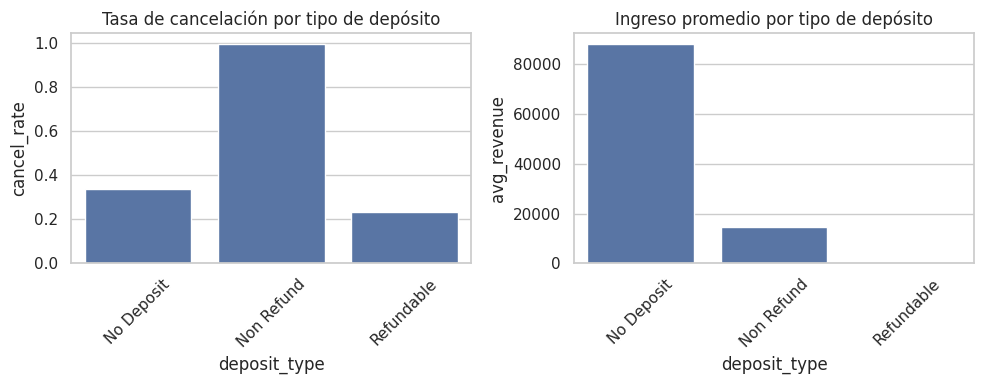

In [97]:
# ------------------------------------------------------------
# 14) ANÁLISIS 11: Impacto de deposit_type en cancelaciones e ingresos
# ------------------------------------------------------------
print("\n=== ANÁLISIS 11: Deposit Type ===")
agg_deposit = df_res.groupby('deposit_type').agg({
    target: 'mean',
    'total_revenue': 'mean',
    'total_revenue': 'count'
}).rename(columns={
    target: 'cancel_rate',
    'total_revenue': 'avg_revenue',
    # 'total_revenue' count renombrado más abajo
}).reset_index()

# Renombrar el conteo correctamente
agg_deposit = agg_deposit.rename(columns={'avg_revenue': 'avg_revenue', 'total_revenue': 'n_reservas'})
print(agg_deposit)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(data=agg_deposit, x='deposit_type', y='cancel_rate')
plt.title('Tasa de cancelación por tipo de depósito')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data=agg_deposit, x='deposit_type', y='avg_revenue')
plt.title('Ingreso promedio por tipo de depósito')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



=== ANÁLISIS 12: Country of Origin ===
    country  n_reservas  cancel_rate     avg_adr
130     PRT       42333     0.650060   90.725820
56      GBR       11003     0.222939   93.713417
53      FRA        9252     0.209036  106.718461
48      ESP        7673     0.283722  113.700387
40      DEU        6477     0.188050  102.331985
78      ITA        3159     0.421969  111.582105
73      IRL        2922     0.284736   94.607238
12      BEL        1937     0.244708  110.929086
22      BRA        1851     0.448406  108.533901
118     NLD        1528     0.253272  105.963240


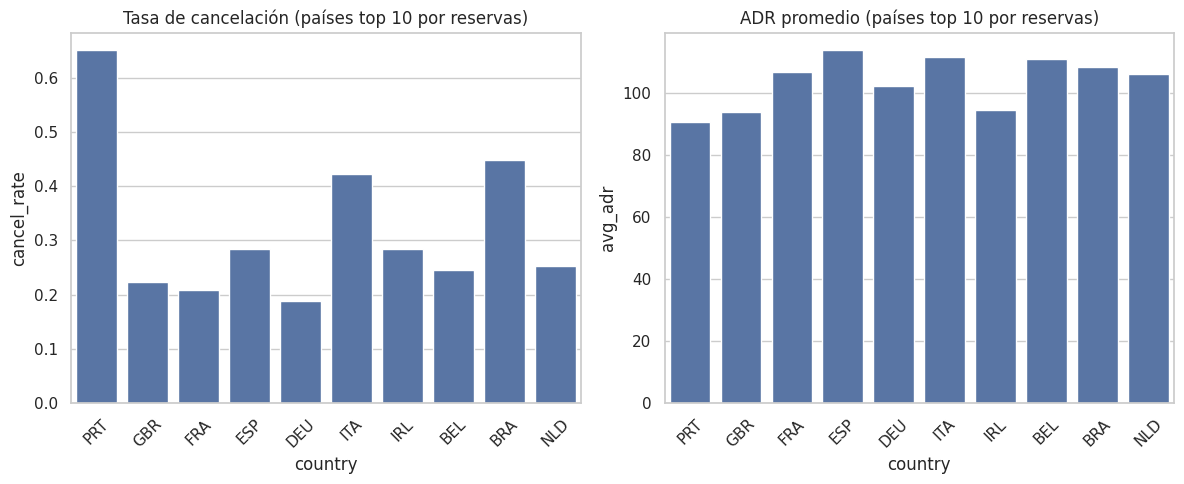

In [98]:
# ------------------------------------------------------------
# 15) ANÁLISIS 12: País de origen (country) vs cancelaciones y ADR
# ------------------------------------------------------------
print("\n=== ANÁLISIS 12: Country of Origin ===")
# Calcular número de reservas, tasa de cancelación y ADR promedio por país
agg_country = df_res.groupby('country').agg({
    target: 'mean',
    'adr': 'mean',
    'arrival_date_year': 'count'
}).rename(columns={
    target: 'cancel_rate',
    'adr': 'avg_adr',
    'arrival_date_year': 'n_reservas'
}).reset_index()

# Filtrar solo países con al menos 200 reservas para mayor robustez
agg_country_filt = agg_country[agg_country['n_reservas'] >= 200].sort_values(by='n_reservas', ascending=False)

print(agg_country_filt[['country', 'n_reservas', 'cancel_rate', 'avg_adr']].head(10))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(data=agg_country_filt.head(10), x='country', y='cancel_rate')
plt.title('Tasa de cancelación (países top 10 por reservas)')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data=agg_country_filt.head(10), x='country', y='avg_adr')
plt.title('ADR promedio (países top 10 por reservas)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



=== ANÁLISIS 13: Booking Changes ===
   booking_changes  cancel_rate  avg_nights  avg_lead_time     avg_adr  \
0              0.0     0.468261    3.396853     110.910717   99.354654   
1              1.0     0.174657    3.712643     104.526870   99.094090   
2              2.0     0.249918    4.130179     110.972268  105.278773   
3              3.0     0.198895    4.110497     115.013812  104.928729   
4              4.0     0.232639    4.409722     109.402778  105.949479   
5              5.0     0.212766    5.234043     114.734043   97.194362   

   n_reservas  
0       88393  
1       10346  
2        3065  
3         724  
4         288  
5          94  


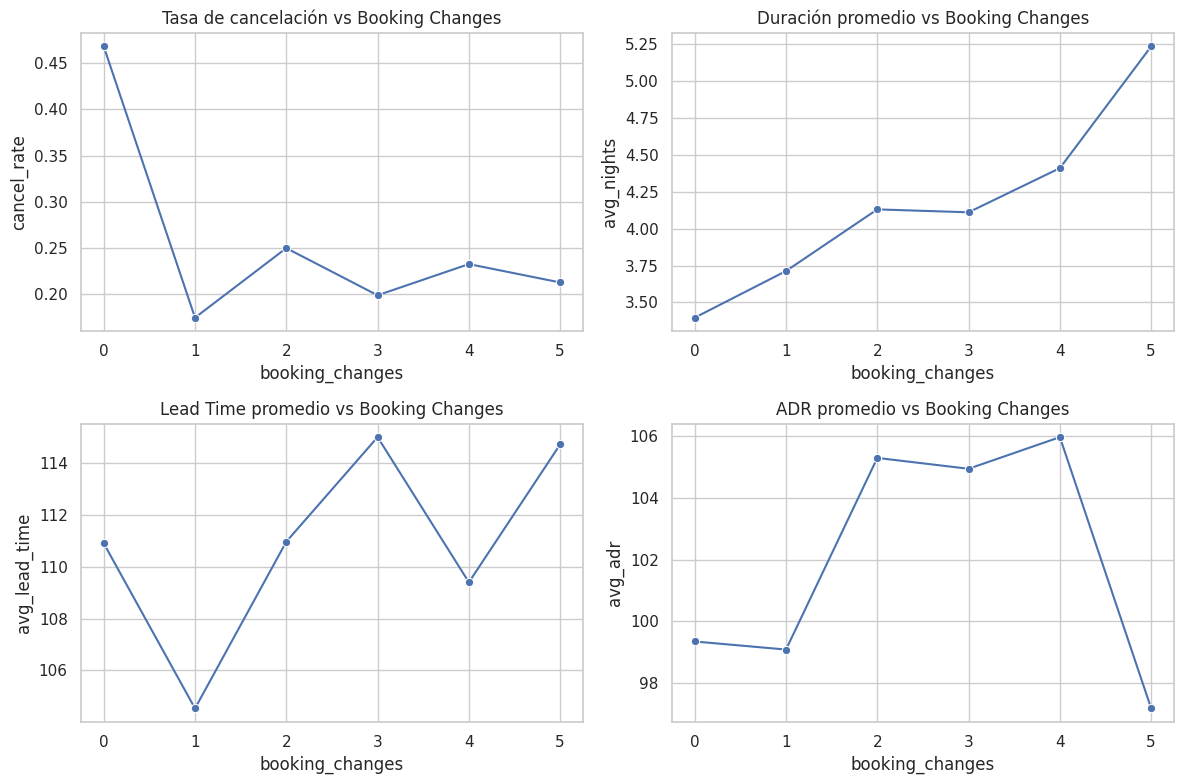

In [99]:
# ------------------------------------------------------------
# 16) ANÁLISIS 13: Efecto de booking_changes en cancelaciones y duración
# ------------------------------------------------------------
print("\n=== ANÁLISIS 13: Booking Changes ===")
agg_changes = df_res.groupby('booking_changes').agg({
    target: 'mean',
    'total_nights': 'mean',
    'lead_time': 'mean',
    'adr': 'mean',
    'booking_changes': 'count'
}).rename(columns={
    target: 'cancel_rate',
    'total_nights': 'avg_nights',
    'lead_time': 'avg_lead_time',
    'adr': 'avg_adr',
    'booking_changes': 'n_reservas'
}).reset_index()

# Filtrar para booking_changes hasta 5 para mejor visualización
agg_changes_filt = agg_changes[agg_changes['booking_changes'] <= 5]

print(agg_changes_filt)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.lineplot(data=agg_changes_filt, x='booking_changes', y='cancel_rate', marker='o')
plt.title('Tasa de cancelación vs Booking Changes')

plt.subplot(2,2,2)
sns.lineplot(data=agg_changes_filt, x='booking_changes', y='avg_nights', marker='o')
plt.title('Duración promedio vs Booking Changes')

plt.subplot(2,2,3)
sns.lineplot(data=agg_changes_filt, x='booking_changes', y='avg_lead_time', marker='o')
plt.title('Lead Time promedio vs Booking Changes')

plt.subplot(2,2,4)
sns.lineplot(data=agg_changes_filt, x='booking_changes', y='avg_adr', marker='o')
plt.title('ADR promedio vs Booking Changes')

plt.tight_layout()
plt.show()

=== ARPAR promedio por tipo de hotel ===
          hotel   avg_arpar  sum_nights
0    City Hotel  103.610170    206003.0
1  Resort Hotel   92.940201    151022.0 



/tmp/ipykernel_6733/4206616515.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_arpar, x='hotel', y='avg_arpar', palette='viridis')


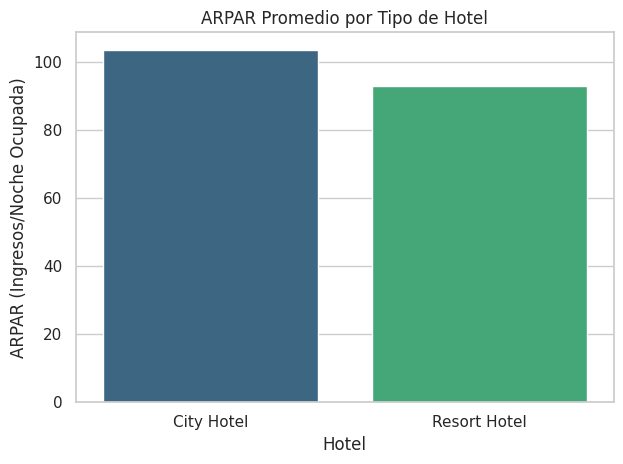

In [100]:
# Asegurarnos de que 'reservation_status_date' es datetime y que
# 'total_revenue' y 'total_nights' están definidos
if df_res.get('reservation_status_date').dtype == object:
    df_res['reservation_status_date'] = pd.to_datetime(df_res['reservation_status_date'])

# Si no existe 'total_nights' o 'total_revenue', crearlas:
if 'total_nights' not in df_res.columns:
    df_res['total_nights'] = df_res['stays_in_weekend_nights'] + df_res['stays_in_week_nights']
if 'total_revenue' not in df_res.columns:
    df_res['total_revenue'] = df_res['adr'] * df_res['total_nights']

# ------------------------------------------------------------
# ANÁLISIS A: RevPAR aproximado (Actual Revenue per Available Room)
# ------------------------------------------------------------
# Nota: Como no disponemos de #habitaciones disponibles, calculamos ARPAR:
df_res['ARPAR'] = df_res['total_revenue'] / df_res['total_nights']

# Agrupar por hotel (City vs Resort)
agg_arpar = df_res.groupby('hotel').agg({
    'ARPAR': 'mean',
    'total_nights': 'sum'
}).rename(columns={'ARPAR': 'avg_arpar', 'total_nights': 'sum_nights'}).reset_index()

print("=== ARPAR promedio por tipo de hotel ===")
print(agg_arpar, "\n")

plt.figure()
sns.barplot(data=agg_arpar, x='hotel', y='avg_arpar', palette='viridis')
plt.title("ARPAR Promedio por Tipo de Hotel")
plt.ylabel("ARPAR (Ingresos/Noche Ocupada)")
plt.xlabel("Hotel")
plt.tight_layout()
plt.show()



In [101]:

# ------------------------------------------------------------
# ANÁLISIS B: Tasa de ocupación implícita (Occupancy Rate proxy)
# ------------------------------------------------------------
# Estimamos "occupancy proxy" como (noche-habitación vendidas) / (noche-habitación totales en el período)
# Determinamos período completo:
min_arrival = df_res['arrival_date_year'].min(), df_res['arrival_date_month'].min()
max_arrival = df_res['arrival_date_year'].max(), df_res['arrival_date_month'].max()
# Calcular meses únicos en el dataset remuestreado
df_res['arrival_date_month'] = pd.Categorical(
    df_res['arrival_date_month'],
    categories=['January','February','March','April','May','June','July','August','September','October','November','December'],
    ordered=True
)
period_months = df_res[['arrival_date_year','arrival_date_month']].drop_duplicates()
n_meses = len(period_months)

# Suponemos, ficticiamente, 100 habitaciones disponibles por hotel para ilustrar
habitaciones_disponibles = 100
# Noche-habitación vendidas totales:
n_nights_vendidas = df_res['total_nights'].sum()
# Noche-habitación disponibles en todo el período (100 habitaciones * n_meses * 30 días promedio)
n_nights_disponibles = habitaciones_disponibles * n_meses * 30
occupancy_rate = n_nights_vendidas / n_nights_disponibles

print(f"=== Tasa de Ocupación proxy (asumiendo 100 habitaciones y 30 días/mes): {occupancy_rate:.3f} ===\n")


=== Tasa de Ocupación proxy (asumiendo 100 habitaciones y 30 días/mes): 4.577 ===



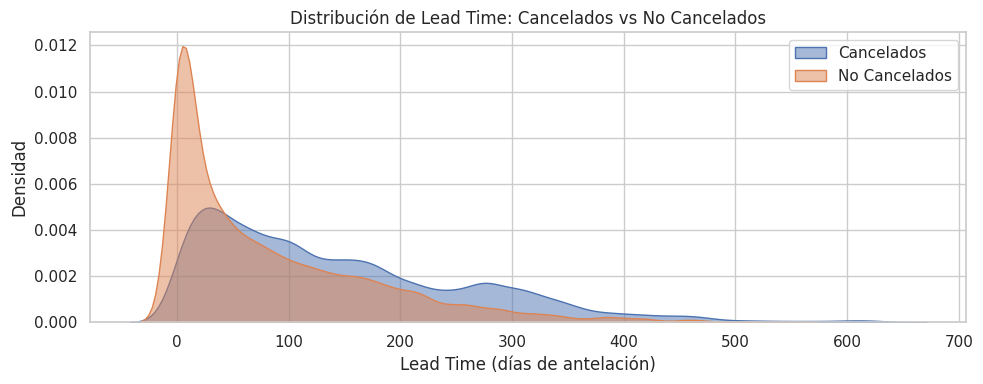

In [102]:

# ------------------------------------------------------------
# ANÁLISIS D: Distribución de lead_time para cancelados vs no cancelados
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
sns.kdeplot(data=df_res[df_res['is_canceled']==1], x='lead_time', label='Cancelados', fill=True, alpha=0.5)
sns.kdeplot(data=df_res[df_res['is_canceled']==0], x='lead_time', label='No Cancelados', fill=True, alpha=0.5)
plt.title("Distribución de Lead Time: Cancelados vs No Cancelados")
plt.xlabel("Lead Time (días de antelación)")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()



=== Yield Curve: ADR vs Lead Time por Mes ===


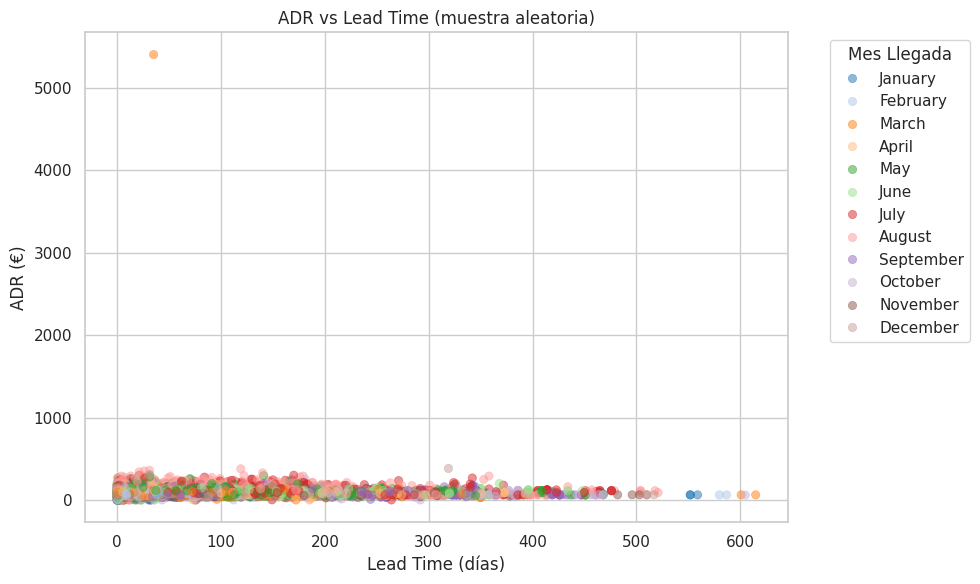

In [103]:


# ------------------------------------------------------------
# ANÁLISIS G: Yield Curve – ADR vs Lead Time por mes
# ------------------------------------------------------------
print("=== Yield Curve: ADR vs Lead Time por Mes ===")
# Para evitar demasiados puntos, tomamos muestra aleatoria de 5000
sample_yield = df_res.sample(5000, random_state=42)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=sample_yield,
    x='lead_time',
    y='adr',
    hue='arrival_date_month',
    palette='tab20',
    alpha=0.5,
    edgecolor=None
)
plt.title("ADR vs Lead Time (muestra aleatoria)")
plt.xlabel("Lead Time (días)")
plt.ylabel("ADR (€)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title='Mes Llegada')
plt.tight_layout()
plt.show()



=== Revenue Mix: Ingresos por Segmento ===
Ingresos por Customer Type:
     customer_type  total_revenue  pct_ingreso
0         Contract     1665530.29     0.045658
1            Group      117019.97     0.003208
2        Transient    28678722.59     0.786179
3  Transient-Party     6017359.28     0.164956 



/tmp/ipykernel_6733/1258314063.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rev_by_cust, x='customer_type', y='pct_ingreso', palette='magma')


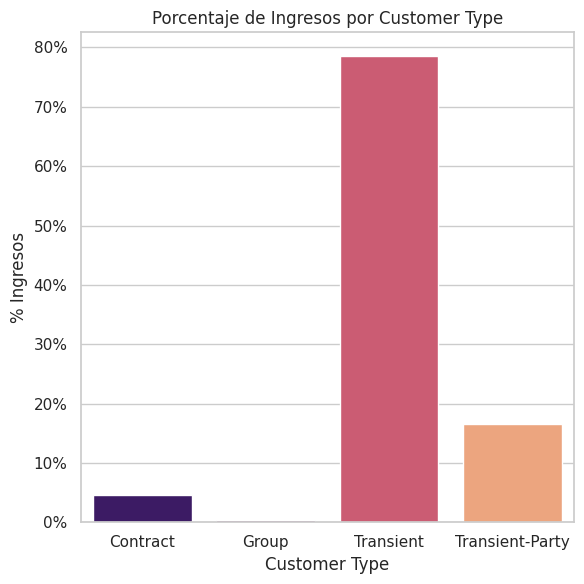

Ingresos por Market Segment:
  market_segment  total_revenue  pct_ingreso
6      Online TA    19860918.86     0.544453
5  Offline TA/TO     7515103.31     0.206014
4         Groups     4581430.34     0.125592
3         Direct     3789519.52     0.103883
2      Corporate      657793.38     0.018032
0       Aviation       69722.70     0.001911
1  Complementary        4096.02     0.000112
7      Undefined          48.00     0.000001 



/tmp/ipykernel_6733/1258314063.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rev_by_market.head(10), x='market_segment', y='pct_ingreso', palette='viridis')


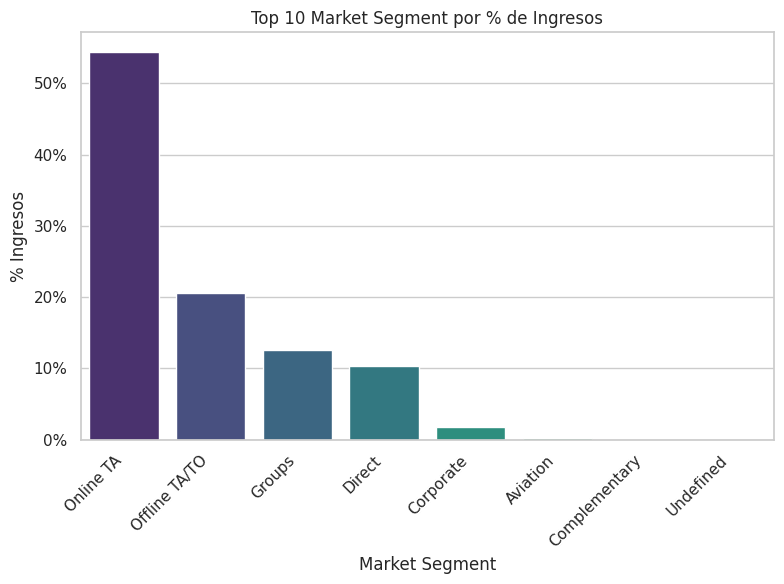

Ingresos por Distribution Channel:
  distribution_channel  total_revenue  pct_ingreso
3                TA/TO    31303718.27     0.858138
1               Direct     4166978.35     0.114231
0            Corporate      971319.28     0.026627
2                  GDS       35445.23     0.000972
4            Undefined        1171.00     0.000032 



/tmp/ipykernel_6733/1258314063.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rev_by_channel, x='distribution_channel', y='pct_ingreso', palette='plasma')


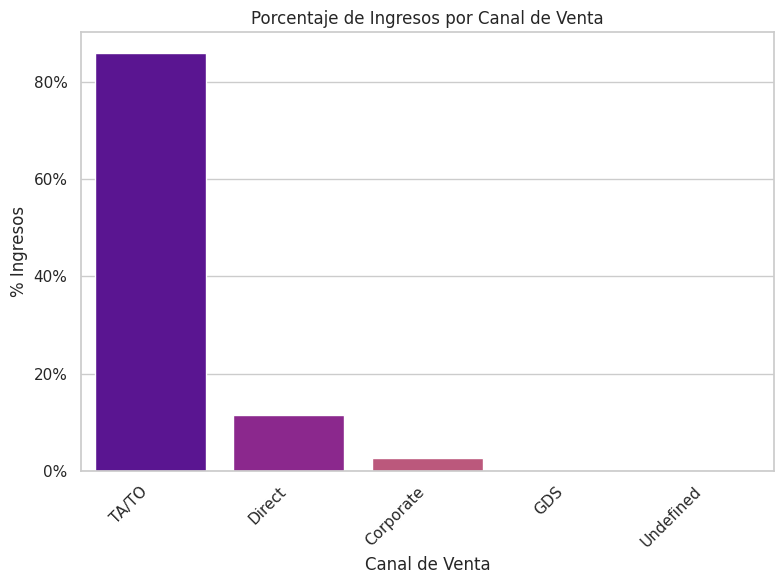

In [104]:


# ------------------------------------------------------------
# ANÁLISIS H: Mezcla de Ingresos (Revenue Mix) por Customer Type, Market Segment y Canal
# ------------------------------------------------------------
print("\n=== Revenue Mix: Ingresos por Segmento ===")
# Total de ingresos global
total_ingresos = df_res['total_revenue'].sum()

# Por Customer Type
rev_by_cust = df_res.groupby('customer_type')['total_revenue'].sum().reset_index()
rev_by_cust['pct_ingreso'] = rev_by_cust['total_revenue'] / total_ingresos
print("Ingresos por Customer Type:")
print(rev_by_cust, "\n")

plt.figure(figsize=(6,6))
sns.barplot(data=rev_by_cust, x='customer_type', y='pct_ingreso', palette='magma')
plt.title("Porcentaje de Ingresos por Customer Type")
plt.ylabel("% Ingresos")
plt.xlabel("Customer Type")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# Por Market Segment
rev_by_market = df_res.groupby('market_segment')['total_revenue'].sum().reset_index()
rev_by_market['pct_ingreso'] = rev_by_market['total_revenue'] / total_ingresos
rev_by_market = rev_by_market.sort_values(by='pct_ingreso', ascending=False)
print("Ingresos por Market Segment:")
print(rev_by_market.head(10), "\n")

plt.figure(figsize=(8,6))
sns.barplot(data=rev_by_market.head(10), x='market_segment', y='pct_ingreso', palette='viridis')
plt.title("Top 10 Market Segment por % de Ingresos")
plt.ylabel("% Ingresos")
plt.xlabel("Market Segment")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Por Distribution Channel
rev_by_channel = df_res.groupby('distribution_channel')['total_revenue'].sum().reset_index()
rev_by_channel['pct_ingreso'] = rev_by_channel['total_revenue'] / total_ingresos
rev_by_channel = rev_by_channel.sort_values(by='pct_ingreso', ascending=False)
print("Ingresos por Distribution Channel:")
print(rev_by_channel, "\n")

plt.figure(figsize=(8,6))
sns.barplot(data=rev_by_channel, x='distribution_channel', y='pct_ingreso', palette='plasma')
plt.title("Porcentaje de Ingresos por Canal de Venta")
plt.ylabel("% Ingresos")
plt.xlabel("Canal de Venta")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


=== Desviación de ADR por Tipo de Habitación ===
  reserved_room_type        mean        std  count
6                  G  172.906773  79.791398   1469
7                  H  185.660236  76.049538    424
2                  C  158.752705  71.664377    743
8                  L   94.000000  64.394617      4
5                  F  164.041873  64.180213   2024
4                  E  122.051804  59.380581   5250
3                  D  118.690556  47.730196  15831
0                  A   89.992179  41.405457  76340
1                  B   89.277578  33.914054    933
9                  P    0.000000   0.000000     12 



/tmp/ipykernel_6733/441735315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adr_stats, x='reserved_room_type', y='std', palette='cividis')


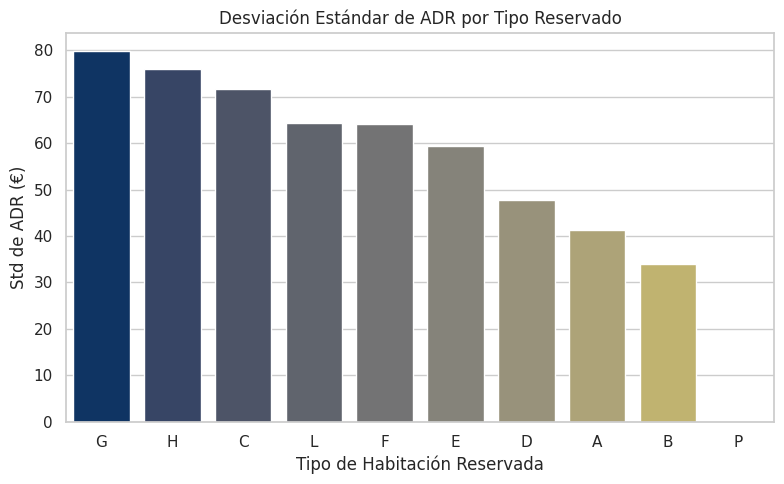

In [105]:


# ------------------------------------------------------------
# ANÁLISIS J: Desviación de ADR dentro de cada tipo de habitación
# ------------------------------------------------------------
print("=== Desviación de ADR por Tipo de Habitación ===")
adr_stats = df_res.groupby('reserved_room_type')['adr'].agg(['mean','std','count']).reset_index().sort_values(by='std', ascending=False)
print(adr_stats, "\n")

plt.figure(figsize=(8,5))
sns.barplot(data=adr_stats, x='reserved_room_type', y='std', palette='cividis')
plt.title("Desviación Estándar de ADR por Tipo Reservado")
plt.ylabel("Std de ADR (€)")
plt.xlabel("Tipo de Habitación Reservada")
plt.tight_layout()
plt.show()


=== Upsell de Peticiones Especiales vs ADR ===


/tmp/ipykernel_6733/120213246.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_res, x='total_of_special_requests', y='adr', palette='coolwarm')


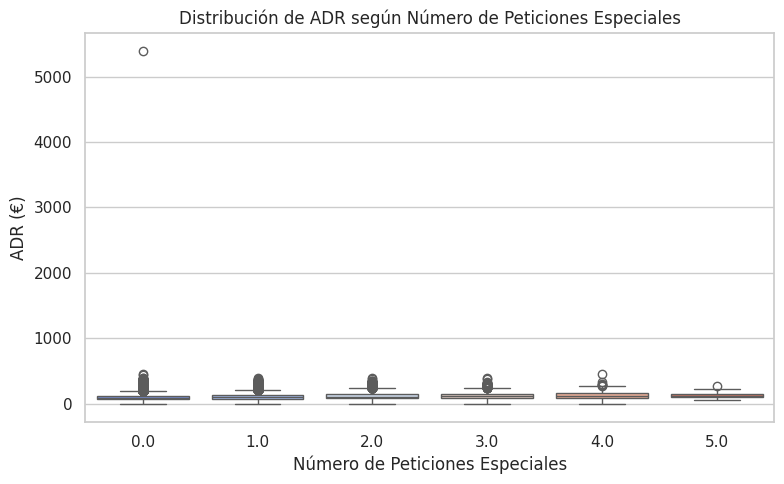

In [106]:


# ------------------------------------------------------------
# ANÁLISIS K: Upsell de servicios (Requests médios) y su impacto en ADR
# ------------------------------------------------------------
print("=== Upsell de Peticiones Especiales vs ADR ===")
# Ya habíamos agrupado en req_group para notas anteriores,
# aquí hacemos un boxplot de ADR por número de peticiones
plt.figure(figsize=(8,5))
sns.boxplot(data=df_res, x='total_of_special_requests', y='adr', palette='coolwarm')
plt.title("Distribución de ADR según Número de Peticiones Especiales")
plt.xlabel("Número de Peticiones Especiales")
plt.ylabel("ADR (€)")
plt.tight_layout()
plt.show()

